<a href="https://colab.research.google.com/github/KenethRojas/AML-Final-Rojas-Keneth/blob/main/AML_Final_Project_Rojas_Keneth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 Capstone Project - Advanced Machine Learning
## TEC-VIII Programa de Especialización en Big Data Analytics aplicada a los Negocios

---

### 📋 Información del Proyecto

| Campo | Información |
|-------|-------------|
| **Nombre del Estudiante** | Keneth Anderson Rojas Cadillo |
| **Título del Proyecto** | Modelo de Propensión para la adquisición de un Seguro Vehicular |
| **Fecha de Entrega** | 19/02/2026 |
| **Profesor** | Carlos Mariño |

---

## 📑 Índice

1. [Resumen Ejecutivo](#1-resumen-ejecutivo)
2. [Configuración del Entorno](#2-configuración-del-entorno)
3. [Definición del Problema de Negocio](#3-definición-del-problema-de-negocio)
4. [Carga y Exploración de Datos](#4-carga-y-exploración-de-datos)
5. [Preprocesamiento de Datos](#5-preprocesamiento-de-datos)
6. [Diseño y Arquitectura del Modelo](#6-diseño-y-arquitectura-del-modelo)
7. [Entrenamiento del Modelo](#7-entrenamiento-del-modelo)
8. [Evaluación y Métricas](#8-evaluación-y-métricas)
9. [Interpretación de Resultados](#9-interpretación-de-resultados)
10. [Conclusiones y Recomendaciones de Negocio](#10-conclusiones-y-recomendaciones-de-negocio)
11. [Referencias](#11-referencias)

---
## 1. Resumen Ejecutivo

**Instrucciones:** Proporcione un resumen conciso (máximo 300 palabras) que incluya:
- Problema de negocio abordado
- Metodología utilizada
- Principales hallazgos
- Impacto esperado en el negocio

---

En este proyecto se aborda el problema de negocio de una empresa de seguros que busca incrementar la efectividad de sus campañas comerciales identificando con anticipación a los clientes con mayor probabilidad de adquirir un seguro vehicular. Actualmente, la oferta puede estar dirigida de forma masiva, elevando costos de contacto y reduciendo el ROI. Por ello, se plantea un modelo predictivo que estime la propensión de compra por cliente.

La metodología sigue un enfoque estándar de ciencia de datos: comprensión del negocio, carga y exploración del dataset, limpieza y preprocesamiento (tratamiento de valores faltantes, codificación de variables y escalamiento cuando corresponda), partición train/validation/test, construcción de un baseline y entrenamiento de modelos de clasificación supervisada. Dado el desbalance del target (minoría de compradores), se priorizan métricas adecuadas como ROC-AUC, PR-AUC, Recall y F1-score, además de calibrar un umbral de decisión alineado a la capacidad del equipo comercial.

Como hallazgos iniciales, se observa que el target está fuertemente desbalanceado, por lo que la Accuracy puede ser engañosa. En consecuencia, el desempeño del modelo debe evaluarse por su capacidad de capturar compradores potenciales con un nivel controlado de falsos positivos. Se espera que el modelo permita segmentar clientes por probabilidad (p. ej., Top deciles) y asignar esfuerzos a los grupos con mayor propensión.

El impacto esperado es una optimización del gasto comercial y de marketing, mayor tasa de conversión, mejor priorización de leads y un incremento del ROI de campañas al concentrar recursos en clientes con mayor probabilidad de compra.

---

## 2. Configuración del Entorno

### 2.1 Verificación de GPU (Recomendado para Deep Learning)

In [1]:
# Verificar si hay GPU disponible
import torch

# Verificar disponibilidad de GPU
if torch.cuda.is_available():
    print(f"✅ GPU disponible: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device('cuda')
else:
    print("⚠️ GPU no disponible. Usando CPU.")
    print("   Recomendación: En Colab, vaya a Runtime > Change runtime type > GPU")
    device = torch.device('cpu')

print(f"\nDispositivo seleccionado: {device}")

⚠️ GPU no disponible. Usando CPU.
   Recomendación: En Colab, vaya a Runtime > Change runtime type > GPU

Dispositivo seleccionado: cpu


### 2.2 Instalación de Librerías Adicionales (si es necesario)

In [2]:
# Descomente e instale las librerías adicionales que necesite
# !pip install transformers
# !pip install pytorch-lightning
# !pip install optuna
# !pip install shap
# !pip install lime

### 2.3 Importación de Librerías

In [3]:
# =====================================================
# LIBRERÍAS FUNDAMENTALES
# =====================================================

# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Deep Learning - TensorFlow/Keras (alternativa)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             mean_squared_error, mean_absolute_error, r2_score)

# Utilidades
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("✅ Todas las librerías importadas correctamente")
print(f"   PyTorch version: {torch.__version__}")
print(f"   TensorFlow version: {tf.__version__}")

✅ Todas las librerías importadas correctamente
   PyTorch version: 2.9.0+cpu
   TensorFlow version: 2.19.0


### 2.4 Conexión con Google Drive (para cargar datos)

In [4]:
# Montar Google Drive para acceder a los datos
from google.colab import drive
drive.mount('/content/drive')

# Definir la ruta base de su proyecto
# Modifique esta ruta según la ubicación de sus datos
BASE_PATH = '/content/drive/MyDrive/AML_Final_Project/'

print(f"✅ Google Drive montado")
print(f"   Ruta base del proyecto: {BASE_PATH}")

Mounted at /content/drive
✅ Google Drive montado
   Ruta base del proyecto: /content/drive/MyDrive/AML_Final_Project/


---
## 3. Definición del Problema de Negocio

### 3.1 Contexto del Negocio

**Instrucciones:** Describa el contexto empresarial, incluyendo:
- Industria/Sector
- Empresa o caso de estudio
- Situación actual

---

Este caso se ubica en la industria de seguros, específicamente en el segmento de seguros vehiculares, donde el crecimiento depende en gran parte de la efectividad de marketing y ventas para captar clientes con alta intención de compra. La empresa del caso (una aseguradora) busca mejorar su capacidad de decisión usando datos históricos de clientes y variables de comportamiento.

En la situación actual, las campañas comerciales suelen ejecutarse con segmentaciones limitadas o reglas simples, lo que deriva en contactos masivos y esfuerzos poco eficientes: se invierte tiempo y presupuesto en clientes con baja probabilidad de conversión, se pierde foco en quienes sí tienen mayor propensión, y el retorno de inversión (ROI) de las campañas se vuelve difícil de optimizar. Además, la compra del seguro es un evento relativamente poco frecuente, lo que suele generar un escenario de desbalance entre compradores y no compradores en los datos.

---

### 3.2 Problema a Resolver

**Instrucciones:** Defina claramente:
- ¿Cuál es el problema específico?
- ¿Por qué es importante resolverlo?
- ¿Cuál es el impacto actual del problema?

---

El problema específico es construir una solución que permita estimar la probabilidad de que un cliente adquiera un seguro vehicular utilizando las variables disponibles. Resolverlo es importante porque permite priorizar a quién contactar y con qué intensidad, alineando los recursos (tiempo del equipo comercial, presupuesto de campañas, canales) hacia los clientes más propensos. El impacto actual de no contar con esta predicción es directo: mayores costos de adquisición por campañas poco focalizadas, menor tasa de conversión al distribuir esfuerzos en perfiles incorrectos y pérdida de oportunidades por no identificar de forma temprana a los clientes con mejor potencial. En conjunto, esto afecta el desempeño comercial y la rentabilidad de las acciones de marketing.

---

### 3.3 Objetivos del Proyecto

**Instrucciones:** Liste los objetivos SMART (Específicos, Medibles, Alcanzables, Relevantes, Temporales)

---

**Objetivo General:**
Desarrollar e implementar un modelo de clasificación que prediga la propensión de compra de un seguro vehicular, logrando un desempeño medible en un conjunto de prueba y permitiendo segmentar clientes para campañas en un horizonte de corto plazo.

**Objetivos Específicos:**
1. Preparar el dataset (limpieza, tratamiento de nulos y transformación de variables) y generar una partición train/validation/test reproducible en la primera etapa del proyecto.  
2. Entrenar un modelo baseline y al menos un modelo mejorado, evaluándolos con métricas adecuadas para desbalance (ROC-AUC, PR-AUC, Recall, F1) y seleccionar el mejor según el objetivo del negocio.  
3. Definir un umbral de decisión y una estrategia de segmentación (por percentiles/deciles) para priorizar clientes, estimando el impacto esperado en conversión y eficiencia comercial.

---

### 3.4 Tipo de Problema de Machine Learning

**Instrucciones:** Identifique el tipo de problema:
- [X] ***Clasificación binaria***
- [ ] Clasificación multiclase
- [ ] Regresión
- [ ] Clustering
- [ ] Series temporales
- [ ] Procesamiento de Lenguaje Natural (NLP)
- [ ] Visión por Computadora
- [ ] Otro: _________

**Justificación:**
La variable objetivo representa dos resultados posibles: compra o no compra del seguro vehicular. Por lo tanto, el modelo debe aprender patrones en los datos de entrada para asignar una probabilidad a la clase positiva (compra). Además, debido al desbalance del target, es apropiado evaluar el desempeño con métricas enfocadas en la clase minoritaria y calibrar un umbral que se alinee a la capacidad operativa del negocio.

---

---
## 4. Carga y Exploración de Datos

### 4.1 Carga de Datos

In [5]:
# =====================================================
# CARGA DE DATOS
# =====================================================

# Opción 1: Cargar desde Google Drive
# df = pd.read_csv(BASE_PATH + 'datos.csv')

# Opción 2: Cargar desde URL
# df = pd.read_csv('https://url-de-sus-datos.com/datos.csv')

# Opción 3: Cargar desde archivo local (subido a Colab)
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv('nombre_archivo.csv')

# Opción 4: Dataset de ejemplo (para testing)
# from sklearn.datasets import load_iris, load_boston, fetch_california_housing
# data = load_iris()
# df = pd.DataFrame(data.data, columns=data.feature_names)
# df['target'] = data.target

# =====================================================
# COMPLETE AQUÍ: Cargue su dataset
# =====================================================

df = pd.read_excel(BASE_PATH + 'dataset.xlsx')

print(f"✅ Dataset cargado exitosamente")
print(f"   Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")

✅ Dataset cargado exitosamente
   Dimensiones: 30,000 filas × 12 columnas


### 4.2 Descripción del Dataset

**Instrucciones:** Describa su dataset:
- Fuente de los datos
- Período de tiempo que cubren
- Descripción de cada variable

---

El dataset fue provisto internamente por la empresa aseguradora como parte del caso de estudio. Por motivos de confidencialidad, la información se entrega **anonimizada**: no contiene datos personales identificables (por ejemplo, nombres, documentos, teléfonos, direcciones) y las variables han sido **enmascaradas** con nombres genéricos (`Variable1` a `Variable10`). Asimismo, el identificador `cliente` funciona únicamente como un **ID técnico** para trazabilidad y validaciones, sin permitir la identificación real de un individuo. Esta anonimización asegura el cumplimiento de buenas prácticas de privacidad y permite realizar el modelamiento sin exponer información sensible del negocio.

---

### 4.3 Exploración Inicial de Datos (EDA)

In [6]:
# =====================================================
# INFORMACIÓN GENERAL DEL DATASET
# =====================================================

print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)

# Primeras filas
print("\n📊 Primeras 5 filas:")
display(df.head())

# Información del dataset
print("\n📋 Información del Dataset:")
print(df.info())

# Estadísticas descriptivas
print("\n📈 Estadísticas Descriptivas:")
display(df.describe())

INFORMACIÓN GENERAL DEL DATASET

📊 Primeras 5 filas:


,cliente,Variable1,Variable2,Variable3,Variable4,Variable5,Variable6,Variable7,Variable8,Variable9,Variable10,Flag_Vehicular
0,1,0,2.045547e+09,252.68,14,0.0,1,6752.46,0,1,1,1
1,2,6,7.860753e+09,15699.95,14,0.0,1,26560.00,0,0,1,1
2,3,1,4.200000e+03,0.00,12,0.0,0,24836.02,1,0,0,1
3,4,5,1.000000e+03,0.00,1,369.0,1,2500.00,0,0,0,1
4,5,1,2.337620e+03,176.09,13,0.0,0,8122.94,0,0,1,1



📋 Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cliente         30000 non-null  int64  
 1   Variable1       30000 non-null  int64  
 2   Variable2       30000 non-null  float64
 3   Variable3       30000 non-null  float64
 4   Variable4       30000 non-null  int64  
 5   Variable5       30000 non-null  float64
 6   Variable6       30000 non-null  int64  
 7   Variable7       30000 non-null  float64
 8   Variable8       30000 non-null  int64  
 9   Variable9       30000 non-null  int64  
 10  Variable10      30000 non-null  int64  
 11  Flag_Vehicular  30000 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 2.7 MB
None

📈 Estadísticas Descriptivas:


,cliente,Variable1,Variable2,Variable3,Variable4,Variable5,Variable6,Variable7,Variable8,Variable9,Variable10,Flag_Vehicular
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0000,30000.000000,30000.00000
mean,15000.500000,3.685367,9.126213e+08,2640.249001,5.488533,522.990933,0.588400,15909.036305,0.508800,0.1638,0.323667,0.05980
std,8660.398374,2.075375,1.868862e+09,6800.717474,3.171278,979.923999,0.492132,20631.527627,0.499931,0.3701,0.467882,0.23712
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0000,0.000000,0.00000
25%,7500.750000,2.000000,1.967750e+03,0.000000,3.000000,0.000000,0.000000,3750.000000,0.000000,0.0000,0.000000,0.00000
50%,15000.500000,4.000000,7.087800e+03,0.000000,5.000000,199.600000,1.000000,9168.830000,1.000000,0.0000,0.000000,0.00000
75%,22500.250000,6.000000,1.066833e+09,435.125000,8.000000,619.770000,1.000000,19600.000000,1.000000,0.0000,1.000000,0.00000
max,30000.000000,6.000000,9.986833e+09,50000.000000,22.000000,70166.100000,1.000000,288655.800000,1.000000,1.0000,1.000000,1.00000


In [7]:
# =====================================================
# ANÁLISIS DE VALORES FALTANTES
# =====================================================

print("=" * 60)
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 60)

# Calcular valores faltantes
missing_data = pd.DataFrame({
    'Total Faltantes': df.isnull().sum(),
    'Porcentaje (%)': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Total Faltantes'] > 0].sort_values('Porcentaje (%)', ascending=False)

if len(missing_data) > 0:
    print("\n⚠️ Variables con valores faltantes:")
    display(missing_data)

    # Visualización de valores faltantes
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_data.index, y='Porcentaje (%)', data=missing_data)
    plt.title('Porcentaje de Valores Faltantes por Variable')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Porcentaje (%)')
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ No hay valores faltantes en el dataset")

ANÁLISIS DE VALORES FALTANTES

✅ No hay valores faltantes en el dataset


ANÁLISIS DE LA VARIABLE OBJETIVO: Flag_Vehicular

📊 Distribución de clases:
Flag_Vehicular
0    28206
1     1794
Name: count, dtype: int64


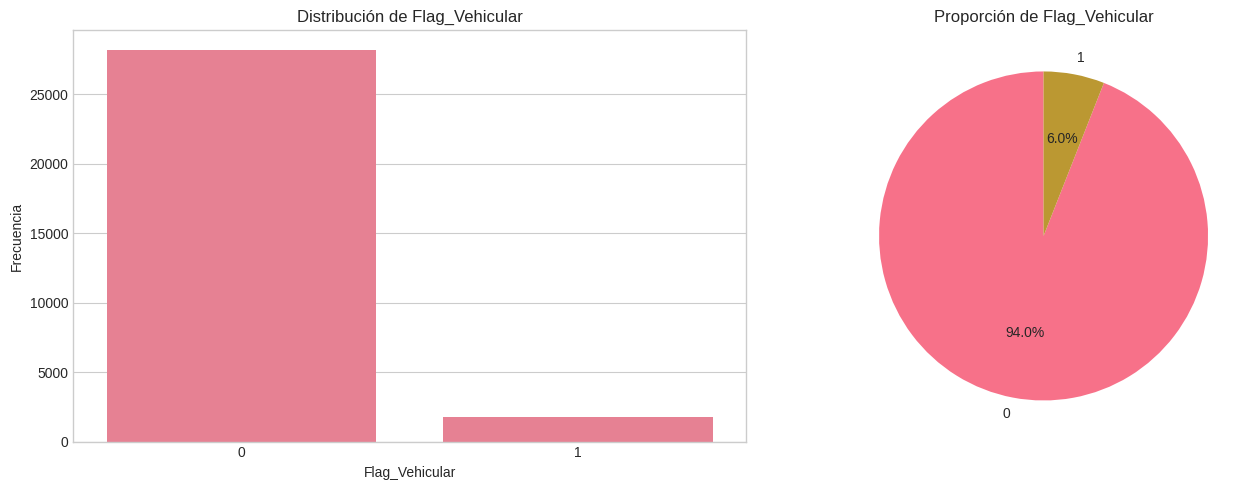


⚠️ ADVERTENCIA: Dataset desbalanceado (ratio 15.72:1)
   Considere técnicas de balanceo: SMOTE, undersampling, class weights


In [8]:
# =====================================================
# ANÁLISIS DE LA VARIABLE OBJETIVO
# =====================================================

# COMPLETE: Especifique el nombre de su variable objetivo
TARGET_COLUMN = 'Flag_Vehicular'  # Cambie 'target' por el nombre de su variable objetivo

print("=" * 60)
print(f"ANÁLISIS DE LA VARIABLE OBJETIVO: {TARGET_COLUMN}")
print("=" * 60)

# Para clasificación
if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() < 20:
    print("\n📊 Distribución de clases:")
    class_dist = df[TARGET_COLUMN].value_counts()
    print(class_dist)

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico de barras
    sns.countplot(data=df, x=TARGET_COLUMN, ax=axes[0])
    axes[0].set_title(f'Distribución de {TARGET_COLUMN}')
    axes[0].set_xlabel(TARGET_COLUMN)
    axes[0].set_ylabel('Frecuencia')

    # Gráfico de pastel
    axes[1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f'Proporción de {TARGET_COLUMN}')

    plt.tight_layout()
    plt.show()

    # Verificar desbalance
    imbalance_ratio = class_dist.max() / class_dist.min()
    if imbalance_ratio > 3:
        print(f"\n⚠️ ADVERTENCIA: Dataset desbalanceado (ratio {imbalance_ratio:.2f}:1)")
        print("   Considere técnicas de balanceo: SMOTE, undersampling, class weights")
else:
    # Para regresión
    print("\n📊 Estadísticas de la variable objetivo:")
    print(df[TARGET_COLUMN].describe())

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histograma
    sns.histplot(df[TARGET_COLUMN], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribución de {TARGET_COLUMN}')

    # Box plot
    sns.boxplot(y=df[TARGET_COLUMN], ax=axes[1])
    axes[1].set_title(f'Box Plot de {TARGET_COLUMN}')

    plt.tight_layout()
    plt.show()

MATRIZ DE CORRELACIONES


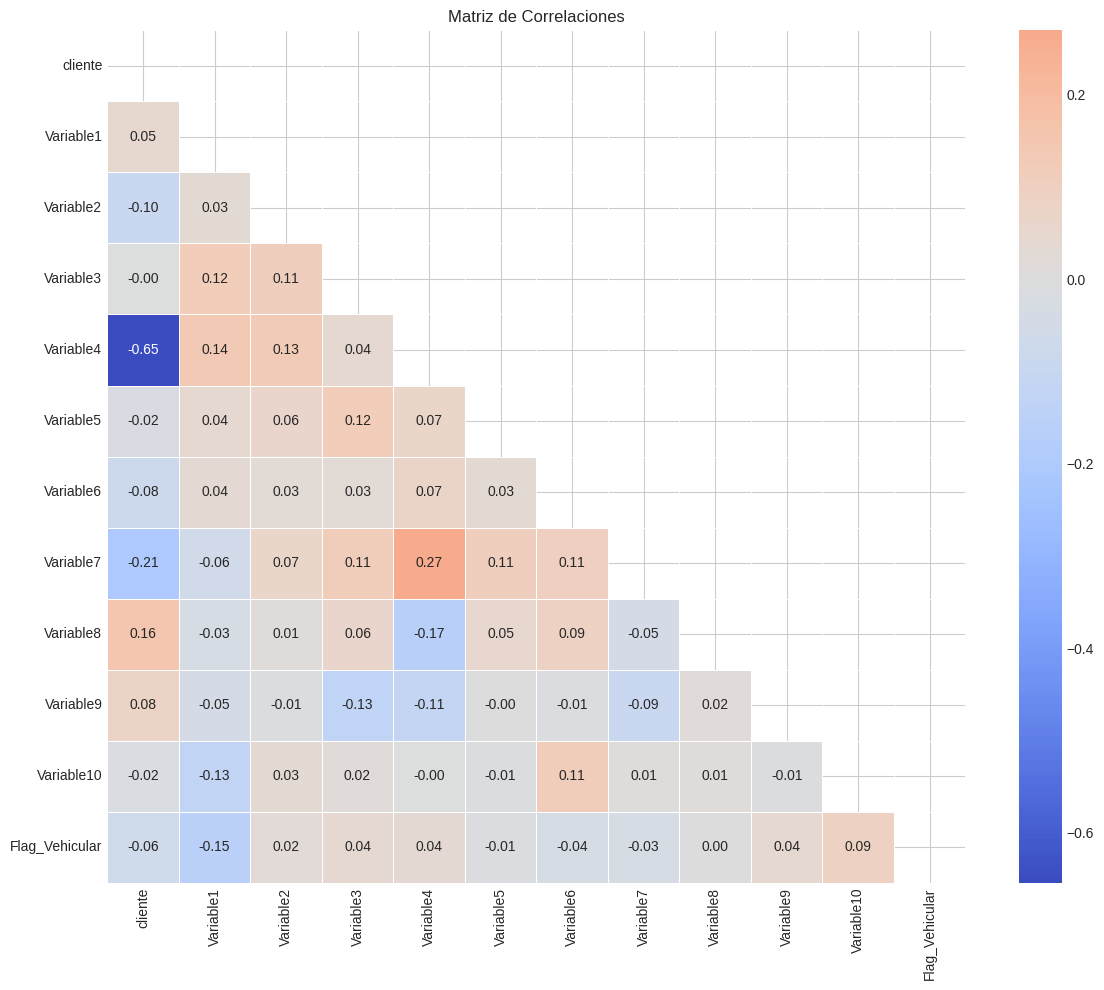


📊 Correlaciones con Flag_Vehicular:
Variable10    0.087837
Variable9     0.041077
Variable3     0.040727
Variable4     0.035533
Variable2     0.021467
Variable8     0.000903
Variable5    -0.013250
Variable7    -0.032622
Variable6    -0.036447
cliente      -0.062557
Variable1    -0.152920
Name: Flag_Vehicular, dtype: float64


In [9]:
# =====================================================
# ANÁLISIS DE CORRELACIONES
# =====================================================

print("=" * 60)
print("MATRIZ DE CORRELACIONES")
print("=" * 60)

# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns

if len(numeric_cols) > 1:
    # Calcular correlaciones
    correlation_matrix = df[numeric_cols].corr()

    # Visualización
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
                center=0, fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlaciones')
    plt.tight_layout()
    plt.show()

    # Correlaciones con la variable objetivo
    if TARGET_COLUMN in numeric_cols:
        print(f"\n📊 Correlaciones con {TARGET_COLUMN}:")
        target_corr = correlation_matrix[TARGET_COLUMN].drop(TARGET_COLUMN).sort_values(ascending=False)
        print(target_corr)
else:
    print("⚠️ No hay suficientes columnas numéricas para análisis de correlación")

VISUALIZACIONES ADICIONALES


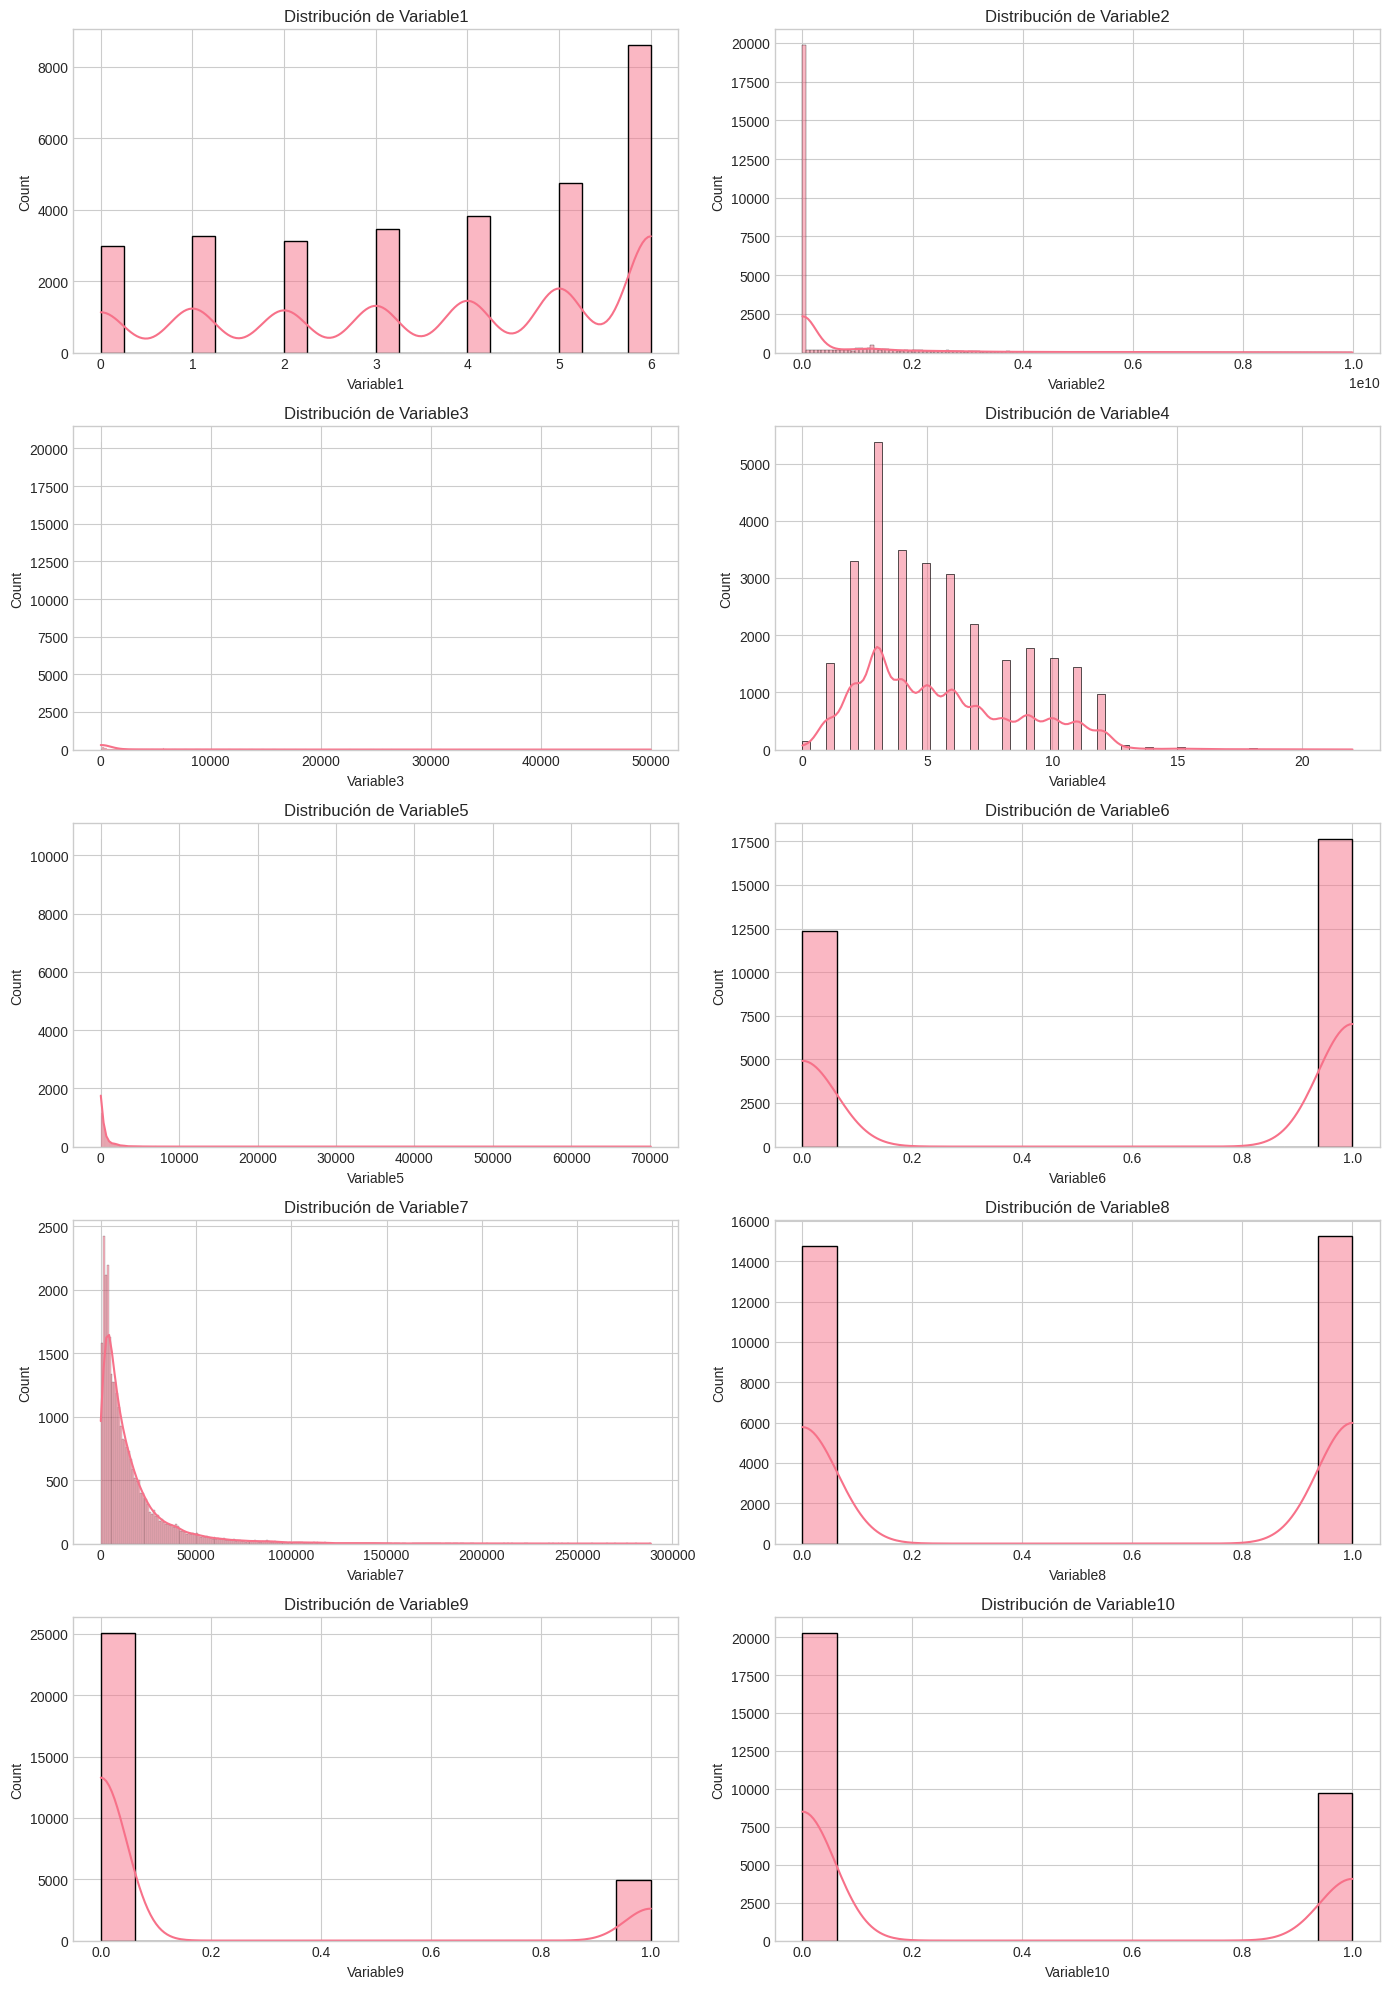

In [10]:
# =====================================================
# VISUALIZACIONES ADICIONALES
# =====================================================

print("=" * 60)
print("VISUALIZACIONES ADICIONALES")
print("=" * 60)

# Distribución de variables numéricas
numeric_cols_plot = df.select_dtypes(include=[np.number]).columns[1:11]  # Las 10 variables del dataset

if len(numeric_cols_plot) > 0:
    n_cols = 2
    n_rows = (len(numeric_cols_plot) + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, col in enumerate(numeric_cols_plot):
        if i < len(axes):
            sns.histplot(df[col], kde=True, ax=axes[i])
            axes[i].set_title(f'Distribución de {col}')

    # Ocultar ejes vacíos
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

### 4.4 Hallazgos del EDA

**Instrucciones:** Resuma los principales hallazgos de la exploración de datos:

---

**Hallazgos Principales:**
1. El dataset contiene 30,000 registros y 12 variables, y no presenta valores faltantes en ninguna columna (todas las variables muestran 30,000 non-null). Esto facilita el preprocesamiento, ya que no será necesario imputar nulos ni definir estrategias de manejo de missingness.
2. La variable objetivo `Flag_Vehicular` está fuertemente desbalanceada: aproximadamente 94% de la clase 0 (no compra) y 6% de la clase 1 (compra), con un ratio cercano a 15.7:1. Esto implica que métricas como Accuracy pueden ser engañosas y que será clave evaluar el modelo con métricas robustas al desbalance (p.ej., PR-AUC, Recall y F1, además de ROC-AUC) y definir un umbral de decisión alineado al negocio.
3. Se observan patrones de distribución relevantes en las variables predictoras: varias variables numéricas muestran asimetría fuerte y presencia de valores extremos (por ejemplo, variables con máximos muy altos y mucha concentración cerca de cero), mientras que otras variables son claramente binarias (0/1) y algunas son discretas con pocos valores posibles. En el análisis de correlación lineal con el target, ninguna variable presenta una relación fuerte (lo esperable en problemas reales), aunque hay señales leves: `Variable10` muestra la mayor correlación positiva (~0.09), mientras `Variable1` tiene una correlación negativa moderada (~-0.15). Esto sugiere que el modelo probablemente necesite capturar relaciones no lineales y/o interacciones para lograr un buen desempeño.

**Problemas Identificados:**
1. Desbalance de clases en la variable objetivo, lo que incrementa el riesgo de entrenar un modelo que favorezca la clase mayoritaria y que “parezca bueno” solo por predecir casi siempre 0. Esto puede reducir la utilidad del modelo en el objetivo real del negocio (capturar compradores potenciales).
2. Presencia de outliers y distribuciones altamente sesgadas en algunas variables numéricas (colas largas y escalas muy distintas), lo cual puede afectar especialmente a modelos sensibles a escala (por ejemplo, regresión logística sin regularización adecuada, KNN, redes neuronales sin normalización) y puede generar inestabilidad si no se controla.

**Acciones a Tomar:**
1. Implementar una estrategia para el desbalance: usar partición estratificada, ajustar el entrenamiento con class_weight y/o técnicas de remuestreo (por ejemplo SMOTE u undersampling, evaluando con cuidado para evitar leakage), y priorizar métricas como PR-AUC/Recall/F1. Además, seleccionar un umbral de probabilidad que se alinee a la capacidad del equipo comercial y al costo de falsos positivos vs falsos negativos.
2. Tratar adecuadamente la escala y asimetría de variables: revisar outliers (IQR/percentiles), aplicar transformaciones cuando tenga sentido (por ejemplo `log1p` en variables muy sesgadas), y utilizar escalamiento/normalización (StandardScaler o RobustScaler) dentro de un pipeline. Adicionalmente, evaluar el rol de `cliente` como identificador y evitar que se use como predictor directo si no aporta señal real (para reducir el riesgo de “memorizar” IDs).

---

---
## 5. Preprocesamiento de Datos

### 5.1 Tratamiento de Valores Faltantes

In [11]:
# =====================================================
# TRATAMIENTO DE VALORES FALTANTES
# =====================================================

print("=" * 60)
print("TRATAMIENTO DE VALORES FALTANTES")
print("=" * 60)

# Crear copia del dataframe
df_clean = df.copy()

# Opción 1: Eliminar filas con valores faltantes
# df_clean = df_clean.dropna()

# Opción 2: Imputar con la media (variables numéricas)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])

# Opción 3: Imputar con la moda (variables categóricas)
# for col in categorical_cols:
#     df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Opción 4: Imputación avanzada con KNN
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de imputación
# =====================================================

print("✅ No se detectaron valores faltantes en el dataset. No se aplicará imputación.")

#print(f"\n✅ Valores faltantes tratados")
#print(f"   Filas restantes: {len(df_clean):,}")

TRATAMIENTO DE VALORES FALTANTES
✅ No se detectaron valores faltantes en el dataset. No se aplicará imputación.


### 5.2 Tratamiento de Outliers

In [12]:
# =====================================================
# DETECCIÓN Y TRATAMIENTO DE OUTLIERS
# =====================================================

print("=" * 60)
print("DETECCIÓN DE OUTLIERS")
print("=" * 60)

def detect_outliers_iqr(data, column):
    """Detecta outliers usando el método IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# Detectar outliers en cada columna numérica
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

outlier_summary = []
for col in numeric_cols:
    n_outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    if n_outliers > 0:
        outlier_summary.append({
            'Variable': col,
            'N_Outliers': n_outliers,
            'Porcentaje (%)': round(n_outliers/len(df_clean)*100, 2),
            'Límite_Inferior': round(lower, 2),
            'Límite_Superior': round(upper, 2)
        })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print("\n⚠️ Variables con outliers detectados:")
    display(outlier_df)
else:
    print("\n✅ No se detectaron outliers significativos")

DETECCIÓN DE OUTLIERS

⚠️ Variables con outliers detectados:


,Variable,N_Outliers,Porcentaje (%),Límite_Inferior,Límite_Superior
0,Variable2,3609,12.03,-1.600245e+09,2.667080e+09
1,Variable3,6463,21.54,-6.526900e+02,1.087810e+03
2,Variable4,109,0.36,-4.500000e+00,1.550000e+01
3,Variable5,2938,9.79,-9.296600e+02,1.549420e+03
4,Variable7,2262,7.54,-2.002500e+04,4.337500e+04
5,Variable9,4914,16.38,0.000000e+00,0.000000e+00
6,Flag_Vehicular,1794,5.98,0.000000e+00,0.000000e+00


In [13]:
# =====================================================
# TRATAMIENTO DE OUTLIERS (OPCIONAL)
# =====================================================

# Opción 1: Eliminar outliers
# for col in numeric_cols:
#     Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
#     IQR = Q3 - Q1
#     df_clean = df_clean[(df_clean[col] >= Q1 - 1.5*IQR) & (df_clean[col] <= Q3 + 1.5*IQR)]

# Opción 2: Capear outliers (winsorizing)
# from scipy.stats import mstats
# for col in numeric_cols:
#     df_clean[col] = mstats.winsorize(df_clean[col], limits=[0.05, 0.05])

# Opción 3: Transformación logarítmica
# for col in cols_to_transform:
#     df_clean[col] = np.log1p(df_clean[col])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de tratamiento
# =====================================================

df_out = df_clean.copy()

# Definir columnas a excluir
TARGET_COL = "Flag_Vehicular"
ID_COL = "cliente"

exclude_cols = [c for c in [TARGET_COL, ID_COL] if c in df_out.columns]

# Detectar columnas numéricas candidatas
numeric_cols = df_out.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

# Excluir columnas binarias (0/1)
binary_cols = [c for c in numeric_cols if set(df_out[c].dropna().unique()).issubset({0, 1})]
continuous_cols = [c for c in numeric_cols if c not in binary_cols]

print("Columnas excluidas (ID/target):", exclude_cols)
print("Columnas binarias excluidas:", binary_cols)
print("Columnas continuas a tratar:", continuous_cols)

# Tratamiento: winsorizing (capping)
# Usamos límites suaves: 1% y 1% (más conservador que 5% y 5%)
from scipy.stats import mstats

for col in continuous_cols:
    df_out[col] = mstats.winsorize(df_out[col], limits=[0.01, 0.01])

# Definir dataset tratado
df_clean = df_out.copy()

print("\n✅ Outliers tratados con winsorización (1% - 99%) en variables continuas.")


Columnas excluidas (ID/target): ['Flag_Vehicular', 'cliente']
Columnas binarias excluidas: ['Variable6', 'Variable8', 'Variable9', 'Variable10']
Columnas continuas a tratar: ['Variable1', 'Variable2', 'Variable3', 'Variable4', 'Variable5', 'Variable7']

✅ Outliers tratados con winsorización (1% - 99%) en variables continuas.


### 5.3 Codificación de Variables Categóricas

In [14]:
# =====================================================
# CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# =====================================================

print("=" * 60)
print("CODIFICACIÓN DE VARIABLES CATEGÓRICAS")
print("=" * 60)

# Identificar variables categóricas
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nVariables categóricas encontradas: {categorical_cols}")

# Opción 1: Label Encoding (para variables ordinales o target)
# le = LabelEncoder()
# df_clean['columna_encoded'] = le.fit_transform(df_clean['columna'])

# Opción 2: One-Hot Encoding (para variables nominales)
# df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Opción 3: Target Encoding
# from sklearn.preprocessing import TargetEncoder
# encoder = TargetEncoder()
# df_clean[categorical_cols] = encoder.fit_transform(df_clean[categorical_cols], df_clean[TARGET_COLUMN])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de codificación
# =====================================================

print("✅ No se detectaron variables categóricas explícitas. No se aplicará codificación (One-Hot/Label).")

#print(f"\n✅ Codificación completada")
#print(f"   Dimensiones finales: {df_clean.shape}")

CODIFICACIÓN DE VARIABLES CATEGÓRICAS

Variables categóricas encontradas: []
✅ No se detectaron variables categóricas explícitas. No se aplicará codificación (One-Hot/Label).


### 5.4 Escalado/Normalización de Features

In [15]:
# =====================================================
# ESCALADO DE FEATURES
# =====================================================

print("=" * 60)
print("ESCALADO DE FEATURES")
print("=" * 60)

# Separar features y target
X = df_clean.drop(columns=['cliente',TARGET_COLUMN])
y = df_clean[TARGET_COLUMN]

print(f"\nDimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")

# Opción 1: StandardScaler (media=0, std=1) - Recomendado para redes neuronales
# scaler = StandardScaler()

# Opción 2: MinMaxScaler (rango [0,1])
# scaler = MinMaxScaler()

# Opción 3: RobustScaler (robusto a outliers)
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# Aplicar escalado
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"\n✅ Escalado completado usando {type(scaler).__name__}")
print(f"   Media de features: {X_scaled.mean().mean():.6f}")
print(f"   Std de features: {X_scaled.std().mean():.6f}")

ESCALADO DE FEATURES

Dimensiones de X: (30000, 10)
Dimensiones de y: (30000,)

✅ Escalado completado usando RobustScaler
   Media de features: 0.724566
   Std de features: 2.183382


### 5.5 División de Datos (Train/Validation/Test)

In [16]:
# =====================================================
# DIVISIÓN DE DATOS
# =====================================================

print("=" * 60)
print("DIVISIÓN DE DATOS")
print("=" * 60)

# División en train (70%), validation (15%), test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=RANDOM_SEED, stratify=y if y.dtype == 'object' or y.nunique() < 20 else None
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_SEED, stratify=y_temp if y_temp.dtype == 'object' or y_temp.nunique() < 20 else None  # 0.176 ≈ 15% del total
)

print(f"\n📊 División de datos:")
print(f"   Training set:   {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   Validation set: {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   Test set:       {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

# Verificar distribución de clases (para clasificación)
if y.dtype == 'object' or y.nunique() < 20:
    print(f"\n📊 Distribución de clases en cada conjunto:")
    print(f"   Train: {dict(y_train.value_counts(normalize=True).round(3))}")
    print(f"   Val:   {dict(y_val.value_counts(normalize=True).round(3))}")
    print(f"   Test:  {dict(y_test.value_counts(normalize=True).round(3))}")

DIVISIÓN DE DATOS

📊 División de datos:
   Training set:   21,012 muestras (70.0%)
   Validation set: 4,488 muestras (15.0%)
   Test set:       4,500 muestras (15.0%)

📊 Distribución de clases en cada conjunto:
   Train: {0: np.float64(0.94), 1: np.float64(0.06)}
   Val:   {0: np.float64(0.94), 1: np.float64(0.06)}
   Test:  {0: np.float64(0.94), 1: np.float64(0.06)}


### 5.6 Preparación de Datos para Deep Learning

In [17]:
# =====================================================
# PREPARACIÓN PARA PYTORCH
# =====================================================

print("=" * 60)
print("PREPARACIÓN DE DATOS PARA PYTORCH")
print("=" * 60)

# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train.values)
X_val_tensor = torch.FloatTensor(X_val.values)
X_test_tensor = torch.FloatTensor(X_test.values)

# Para clasificación
if y.dtype == 'object' or y.nunique() < 20:
    # Codificar labels si es necesario
    if y_train.dtype == 'object':
        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_val_encoded = label_encoder.transform(y_val)
        y_test_encoded = label_encoder.transform(y_test)
    else:
        y_train_encoded = y_train.values
        y_val_encoded = y_val.values
        y_test_encoded = y_test.values

    y_train_tensor = torch.LongTensor(y_train_encoded)
    y_val_tensor = torch.LongTensor(y_val_encoded)
    y_test_tensor = torch.LongTensor(y_test_encoded)
else:
    # Para regresión
    y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
    y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)
    y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

# Crear DataLoaders
BATCH_SIZE = 32  # Ajuste según su dataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ DataLoaders creados")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Batches de entrenamiento: {len(train_loader)}")
print(f"   Batches de validación: {len(val_loader)}")
print(f"   Batches de test: {len(test_loader)}")

PREPARACIÓN DE DATOS PARA PYTORCH

✅ DataLoaders creados
   Batch size: 32
   Batches de entrenamiento: 657
   Batches de validación: 141
   Batches de test: 141


In [18]:
# =====================================================
# PREPARACIÓN PARA TENSORFLOW/KERAS (ALTERNATIVA)
# =====================================================

print("=" * 60)
print("PREPARACIÓN DE DATOS PARA TENSORFLOW/KERAS")
print("=" * 60)

# Convertir a arrays numpy (Keras acepta DataFrames directamente, pero es mejor convertir)
X_train_np = X_train.values.astype('float32')
X_val_np = X_val.values.astype('float32')
X_test_np = X_test.values.astype('float32')

# Para clasificación: One-hot encoding del target
if y.dtype == 'object' or y.nunique() < 20:
    num_classes = y.nunique()
    y_train_np = keras.utils.to_categorical(y_train_encoded, num_classes)
    y_val_np = keras.utils.to_categorical(y_val_encoded, num_classes)
    y_test_np = keras.utils.to_categorical(y_test_encoded, num_classes)
else:
    y_train_np = y_train.values.astype('float32')
    y_val_np = y_val.values.astype('float32')
    y_test_np = y_test.values.astype('float32')

print(f"\n✅ Datos preparados para TensorFlow/Keras")
print(f"   Shape X_train: {X_train_np.shape}")
print(f"   Shape y_train: {y_train_np.shape}")

PREPARACIÓN DE DATOS PARA TENSORFLOW/KERAS

✅ Datos preparados para TensorFlow/Keras
   Shape X_train: (21012, 10)
   Shape y_train: (21012, 2)


---
## 6. Diseño y Arquitectura del Modelo

### 6.1 Justificación de la Arquitectura

**Instrucciones:** Justifique la elección de su arquitectura de red neuronal:
- ¿Por qué eligió este tipo de arquitectura?
- ¿Qué alternativas consideró?
- ¿Cómo determinó el número de capas y neuronas?

---

Elegí una arquitectura de red neuronal feed-forward (MLP) para este problema porque el dataset está compuesto por variables tabulares numéricas (features ya escaladas) y el objetivo es una clasificación binaria (propensión de compra). En este tipo de datos, una MLP suele funcionar bien como aproximador no lineal: permite capturar interacciones entre variables que no se observan con correlaciones lineales simples, algo relevante en este caso porque el EDA mostró que ninguna variable, por sí sola, tiene una relación fuerte con la variable objetivo. Además, una arquitectura densa es relativamente simple de implementar, entrenar e interpretar en comparación con modelos más complejos, y sirve como un buen punto de partida para establecer un baseline de Deep Learning.

Como alternativas, consideré principalmente:
1. Modelos clásicos de machine learning para datos tabulares como Regresión Logística y modelos basados en árboles (Random Forest / Gradient Boosting), que suelen rendir muy bien en problemas estructurados
2. Arquitecturas más avanzadas para tabular como TabNet o modelos tipo Transformer para tabular, aunque estas requieren mayor tuning, más tiempo de entrenamiento y una justificación más fuerte para el alcance del proyecto.

Dado que el objetivo del notebook es construir un modelo DL completo y defendible, la MLP ofrece un equilibrio adecuado entre capacidad predictiva, simplicidad y facilidad de control del sobreajuste.

El número de capas y neuronas se definió combinando criterio práctico y control de complejidad. Partí de una arquitectura compacta (2–3 capas ocultas) porque el dataset tiene un número reducido de features (alrededor de 10 variables predictoras) y un tamaño moderado de datos (30,000 registros), por lo que una red demasiado profunda podría sobreajustar sin aportar mejoras reales. La selección de neuronas sigue un esquema decreciente (por ejemplo 64 → 32 → 16), que ayuda a aprender representaciones gradualmente más abstractas y a reducir el número de parámetros hacia la salida. Para mejorar la generalización, se considera el uso de regularización mediante Dropout y/o L2, junto con Early Stopping basado en el desempeño en validación. Finalmente, el desbalance de clases observado (~6% positivos) influye en el diseño del entrenamiento más que en la arquitectura: se planea compensarlo usando class weights o `pos_weight` (según el framework) y evaluando con métricas enfocadas en la clase positiva (PR-AUC, Recall, F1), asegurando que el modelo sea útil para priorización comercial y no solo para maximizar accuracy.

---

### 6.2 Definición del Modelo

In [19]:
# =====================================================
# DEFINICIÓN DEL MODELO CON PYTORCH
# =====================================================

class NeuralNetwork(nn.Module):
    """
    Red Neuronal para [Clasificación/Regresión]

    Arquitectura:
    - Capa de entrada: [n_features] neuronas
    - Capas ocultas: [Describir]
    - Capa de salida: [n_outputs] neuronas
    """

    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        super(NeuralNetwork, self).__init__()

        layers = []
        prev_size = input_size

        # Capas ocultas
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Capa de salida
        layers.append(nn.Linear(prev_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# =====================================================
# CONFIGURACIÓN DEL MODELO
# =====================================================

INPUT_SIZE = X_train.shape[1]
HIDDEN_SIZES = [64, 32, 16]  # Ajuste según su problema
OUTPUT_SIZE = y.nunique() if (y.dtype == 'object' or y.nunique() < 20) else 1
DROPOUT_RATE = 0.3

# Crear modelo
model_pytorch = NeuralNetwork(INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE, DROPOUT_RATE)
model_pytorch = model_pytorch.to(device)

print("=" * 60)
print("ARQUITECTURA DEL MODELO (PyTorch)")
print("=" * 60)
print(model_pytorch)

# Contar parámetros
total_params = sum(p.numel() for p in model_pytorch.parameters())
trainable_params = sum(p.numel() for p in model_pytorch.parameters() if p.requires_grad)
print(f"\n📊 Parámetros totales: {total_params:,}")
print(f"   Parámetros entrenables: {trainable_params:,}")

ARQUITECTURA DEL MODELO (PyTorch)
NeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)

📊 Parámetros totales: 3,570
   Parámetros entrenables: 3,570


In [20]:
# =====================================================
# DEFINICIÓN DEL MODELO CON KERAS (ALTERNATIVA)
# =====================================================

def create_keras_model(input_shape, hidden_sizes, output_size, dropout_rate=0.3, task='classification'):
    """
    Crea un modelo de red neuronal con Keras.

    Args:
        input_shape: Dimensión de entrada
        hidden_sizes: Lista con el número de neuronas por capa oculta
        output_size: Número de neuronas de salida
        dropout_rate: Tasa de dropout
        task: 'classification' o 'regression'
    """
    model = keras.Sequential()

    # Capa de entrada
    model.add(layers.Input(shape=(input_shape,)))

    # Capas ocultas
    for hidden_size in hidden_sizes:
        model.add(layers.Dense(hidden_size))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(dropout_rate))

    # Capa de salida
    if task == 'classification':
        '''
        if output_size == 2:
            model.add(layers.Dense(2, activation='sigmoid'))
        else:
            model.add(layers.Dense(output_size, activation='softmax'))
        '''
        model.add(layers.Dense(output_size, activation='softmax'))  # output_size=2
    else:
        model.add(layers.Dense(1, activation='linear'))

    return model

# Crear modelo Keras
TASK = 'classification'  # Cambie a 'regression' si es necesario

model_keras = create_keras_model(
    input_shape=INPUT_SIZE,
    hidden_sizes=HIDDEN_SIZES,
    output_size=OUTPUT_SIZE,
    dropout_rate=DROPOUT_RATE,
    task=TASK
)

print("=" * 60)
print("ARQUITECTURA DEL MODELO (Keras)")
print("=" * 60)
model_keras.summary()

ARQUITECTURA DEL MODELO (Keras)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,794 (14.82 KB)

 Trainable params: 3,570 (13.95 KB)

 Non-trainable params: 224 (896.00 B)

### 6.3 Diagrama de la Arquitectura

**Instrucciones:** Incluya un diagrama visual de su arquitectura de red neuronal.

---

La arquitectura corresponde a una red neuronal densa (MLP) para datos tabulares. Recibe 10 features numéricas escaladas como entrada, pasa por tres capas ocultas (64→32→16) con Batch Normalization para estabilizar el entrenamiento, activación ReLU para introducir no linealidad y Dropout (0.3) para reducir overfitting. La capa de salida tiene 2 neuronas (una por cada clase: 0 = no compra, 1 = compra) y produce dos logits. Durante el entrenamiento se utiliza `CrossEntropyLoss`, por lo que no se aplica Softmax dentro del modelo (la pérdida lo incorpora internamente). En la etapa de inferencia, si se requiere interpretar el resultado como probabilidad, se aplica `Softmax` a los logits y se toma la probabilidad asociada a la clase positiva (clase 1).



```
Input Layer          Hidden Layer 1      Hidden Layer 2     Hidden Layer 3       Output Layer
[n_features=10] -->  [64 neurons]   -->  [32 neurons]  -->  [16 neurons]   -->   [2 neurons]
                     + BatchNorm          + BatchNorm         + BatchNorm          (logits)
                     + ReLU               + ReLU              + ReLU               + Softmax (solo inferencia)
                     + Dropout(0.3)       + Dropout(0.3)      + Dropout(0.3)

```

---

---
## 7. Entrenamiento del Modelo

### 7.1 Configuración del Entrenamiento

In [21]:
# =====================================================
# HIPERPARÁMETROS DE ENTRENAMIENTO
# =====================================================

print("=" * 60)
print("CONFIGURACIÓN DEL ENTRENAMIENTO")
print("=" * 60)

# Hiperparámetros
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 32
EARLY_STOPPING_PATIENCE = 10

print(f"\n📋 Hiperparámetros:")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")

CONFIGURACIÓN DEL ENTRENAMIENTO

📋 Hiperparámetros:
   Learning Rate: 0.001
   Epochs: 100
   Batch Size: 32
   Early Stopping Patience: 10


In [22]:
# =====================================================
# CONFIGURACIÓN DE LOSS Y OPTIMIZADOR (PyTorch)
# =====================================================

# Seleccionar función de pérdida según el tipo de problema
'''
if y.dtype == 'object' or y.nunique() < 20:
    # Clasificación
    criterion = nn.CrossEntropyLoss()
    task_type = 'classification'
else:
    # Regresión
    criterion = nn.MSELoss()
    task_type = 'regression'
'''
if y.dtype == 'object' or y.nunique() < 20:
    task_type = 'classification'
    # --- Peso por clase para manejar desbalance ---
    # y_train debe ser 0/1 (o clases enteras)
    class_counts = torch.bincount(torch.tensor(y_train.values, dtype=torch.long))
    # Evitar división por 0
    class_counts = class_counts.clamp(min=1)
    # Pesos inversamente proporcionales a la frecuencia
    class_weights = (class_counts.sum() / class_counts).float().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
else:
    task_type = 'regression'
    criterion = nn.MSELoss()

# Optimizador
optimizer = optim.Adam(model_pytorch.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5 #, verbose=True
)

print(f"\n📋 Configuración:")
print(f"   Tipo de problema: {task_type}")
print(f"   Función de pérdida: {criterion}")
print(f"   Optimizador: Adam")
print(f"   Scheduler: ReduceLROnPlateau")


📋 Configuración:
   Tipo de problema: classification
   Función de pérdida: CrossEntropyLoss()
   Optimizador: Adam
   Scheduler: ReduceLROnPlateau


### 7.2 Entrenamiento del Modelo (PyTorch)

In [23]:
# =====================================================
# FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
# =====================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena el modelo por una época."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if task_type == 'classification':
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total if task_type == 'classification' else None

    return avg_loss, accuracy

def evaluate(model, val_loader, criterion, device):
    """Evalúa el modelo en el conjunto de validación."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            if task_type == 'classification':
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total if task_type == 'classification' else None

    return avg_loss, accuracy

In [24]:
# =====================================================
# ENTRENAMIENTO DEL MODELO (PyTorch)
# =====================================================

print("=" * 60)
print("ENTRENAMIENTO DEL MODELO")
print("=" * 60)

# Historial de entrenamiento
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print(f"\n🚀 Iniciando entrenamiento...\n")

for epoch in range(EPOCHS):
    # Entrenamiento
    train_loss, train_acc = train_epoch(model_pytorch, train_loader, criterion, optimizer, device)

    # Validación
    val_loss, val_acc = evaluate(model_pytorch, val_loader, criterion, device)

    # Guardar historial
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    if task_type == 'classification':
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    # Imprimir progreso cada 10 épocas
    if (epoch + 1) % 10 == 0 or epoch == 0:
        if task_type == 'classification':
            print(f"Época {epoch+1:3d}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        else:
            print(f"Época {epoch+1:3d}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model_pytorch.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n⚠️ Early stopping en época {epoch+1}")
            break

# Cargar mejor modelo
if best_model_state is not None:
    model_pytorch.load_state_dict(best_model_state)
    print(f"\n✅ Mejor modelo cargado (Val Loss: {best_val_loss:.4f})")

print(f"\n🎉 Entrenamiento completado!")

ENTRENAMIENTO DEL MODELO

🚀 Iniciando entrenamiento...

Época   1/100 | Train Loss: 0.6735 | Train Acc: 0.6275 | Val Loss: 0.6284 | Val Acc: 0.6609
Época  10/100 | Train Loss: 0.6083 | Train Acc: 0.6948 | Val Loss: 0.6000 | Val Acc: 0.7239
Época  20/100 | Train Loss: 0.5979 | Train Acc: 0.7124 | Val Loss: 0.5940 | Val Acc: 0.7132
Época  30/100 | Train Loss: 0.5919 | Train Acc: 0.7233 | Val Loss: 0.5831 | Val Acc: 0.6562
Época  40/100 | Train Loss: 0.5900 | Train Acc: 0.7173 | Val Loss: 0.5765 | Val Acc: 0.6787
Época  50/100 | Train Loss: 0.5867 | Train Acc: 0.7266 | Val Loss: 0.5722 | Val Acc: 0.7221
Época  60/100 | Train Loss: 0.5756 | Train Acc: 0.7302 | Val Loss: 0.5763 | Val Acc: 0.6954
Época  70/100 | Train Loss: 0.5754 | Train Acc: 0.7319 | Val Loss: 0.5870 | Val Acc: 0.6747

⚠️ Early stopping en época 73

✅ Mejor modelo cargado (Val Loss: 0.5678)

🎉 Entrenamiento completado!


### 7.3 Entrenamiento del Modelo (Keras - Alternativa)

In [25]:
# =====================================================
# ENTRENAMIENTO DEL MODELO (KERAS)
# =====================================================

# Compilar modelo
if TASK == 'classification':
    if OUTPUT_SIZE == 2:
        model_keras.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    else:
        model_keras.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
else:
    model_keras.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )

# Callbacks
keras_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

# Entrenar
print("=" * 60)
print("ENTRENAMIENTO DEL MODELO (KERAS)")
print("=" * 60)

history_keras = model_keras.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=keras_callbacks,
    verbose=1
)

print("\n🎉 Entrenamiento completado!")

ENTRENAMIENTO DEL MODELO (KERAS)
Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6892 - loss: 0.6343 - val_accuracy: 0.9403 - val_loss: 0.2326 - learning_rate: 0.0010
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9399 - loss: 0.2555 - val_accuracy: 0.9403 - val_loss: 0.2147 - learning_rate: 0.0010
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9402 - loss: 0.2370 - val_accuracy: 0.9403 - val_loss: 0.2136 - learning_rate: 0.0010
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9402 - loss: 0.2281 - val_accuracy: 0.9403 - val_loss: 0.2111 - learning_rate: 0.0010
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9402 - loss: 0.2248 - val_accuracy: 0.9403 - val_loss: 0.2099 - learning_rate: 0.0010
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9402 - loss: 0.2206 - val_accuracy: 0.9403 - val_loss: 0.2075 - learning_rate: 0.0010
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/s

### 7.4 Visualización del Entrenamiento

CURVAS DE APRENDIZAJE


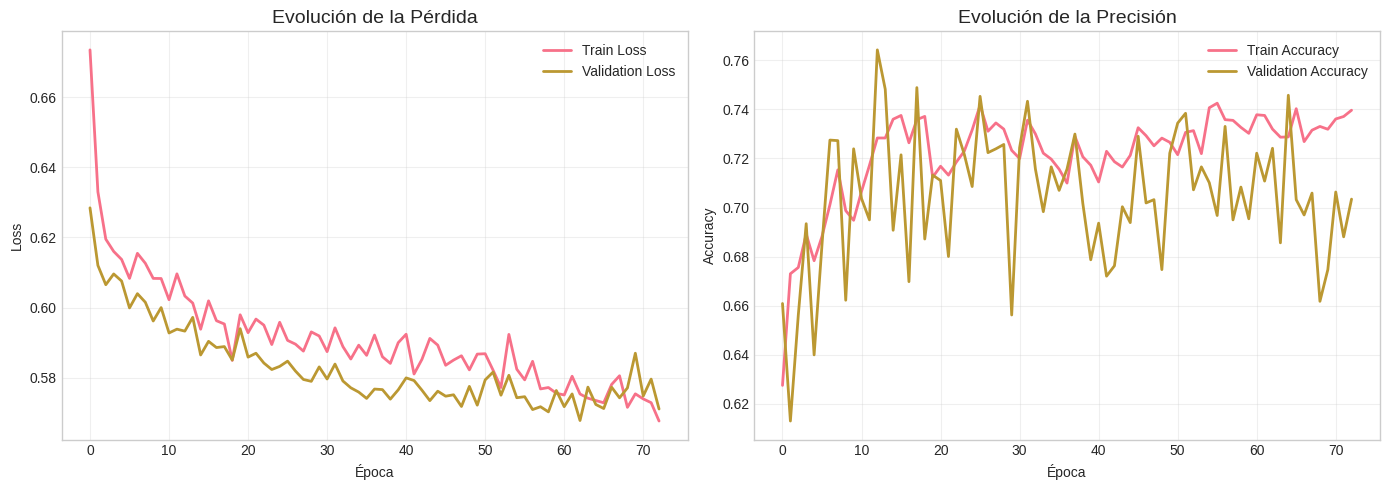


📊 Análisis del Entrenamiento:
   Épocas completadas: 73
   Mejor val_loss: 0.5678 (época 63)
   Mejor val_acc: 0.7643 (época 13)


In [26]:
# =====================================================
# VISUALIZACIÓN DEL PROCESO DE ENTRENAMIENTO
# =====================================================

print("=" * 60)
print("CURVAS DE APRENDIZAJE")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdida
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Evolución de la Pérdida', fontsize=14)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de precisión (solo para clasificación)
if task_type == 'classification':
    axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Evolución de la Precisión', fontsize=14)
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'N/A para Regresión', ha='center', va='center', fontsize=14)
    axes[1].set_title('Precisión (No aplica)')

plt.tight_layout()
plt.show()

# Análisis del entrenamiento
print("\n📊 Análisis del Entrenamiento:")
print(f"   Épocas completadas: {len(history['train_loss'])}")
print(f"   Mejor val_loss: {min(history['val_loss']):.4f} (época {history['val_loss'].index(min(history['val_loss']))+1})")
if task_type == 'classification':
    print(f"   Mejor val_acc: {max(history['val_acc']):.4f} (época {history['val_acc'].index(max(history['val_acc']))+1})")

---
## 8. Evaluación y Métricas

### 8.1 Evaluación en el Conjunto de Test

In [27]:
# =====================================================
# EVALUACIÓN EN EL CONJUNTO DE TEST
# =====================================================

print("=" * 60)
print("EVALUACIÓN EN CONJUNTO DE TEST")
print("=" * 60)

# Hacer predicciones
model_pytorch.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    outputs = model_pytorch(X_test_device)

    if task_type == 'classification':
        _, y_pred = torch.max(outputs, 1)
        y_pred = y_pred.cpu().numpy()
        y_true = y_test_tensor.numpy()
        y_proba = torch.softmax(outputs, dim=1).cpu().numpy()
    else:
        y_pred = outputs.cpu().numpy().flatten()
        y_true = y_test_tensor.numpy().flatten()

print(f"\n✅ Predicciones realizadas: {len(y_pred)} muestras")

EVALUACIÓN EN CONJUNTO DE TEST

✅ Predicciones realizadas: 4500 muestras


MÉTRICAS DE CLASIFICACIÓN

📊 Métricas Principales:
   Accuracy:  0.7044
   Precision: 0.9193
   Recall:    0.7044
   F1-Score:  0.7819

📋 Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      4231
           1       0.12      0.65      0.21       269

    accuracy                           0.70      4500
   macro avg       0.55      0.68      0.51      4500
weighted avg       0.92      0.70      0.78      4500



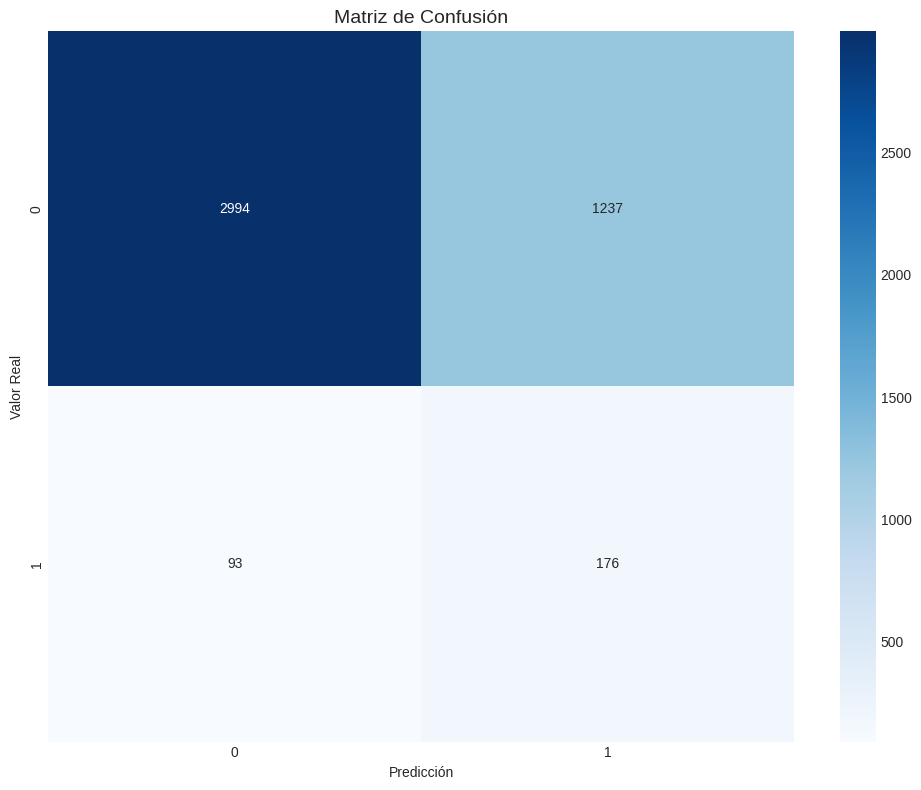

In [28]:
# =====================================================
# MÉTRICAS DE CLASIFICACIÓN
# =====================================================

if task_type == 'classification':
    print("=" * 60)
    print("MÉTRICAS DE CLASIFICACIÓN")
    print("=" * 60)

    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n📊 Métricas Principales:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    # Reporte de clasificación completo
    print(f"\n📋 Reporte de Clasificación Detallado:")
    print(classification_report(y_true, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(OUTPUT_SIZE),
                yticklabels=range(OUTPUT_SIZE))
    plt.title('Matriz de Confusión', fontsize=14)
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.tight_layout()
    plt.show()

In [29]:
# =====================================================
# MÉTRICAS DE REGRESIÓN
# =====================================================

if task_type == 'regression':
    print("=" * 60)
    print("MÉTRICAS DE REGRESIÓN")
    print("=" * 60)

    # Calcular métricas
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 Métricas de Regresión:")
    print(f"   MSE:  {mse:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   R²:   {r2:.4f}")

    # Gráfico de predicciones vs valores reales
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Scatter plot
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_xlabel('Valor Real')
    axes[0].set_ylabel('Predicción')
    axes[0].set_title('Predicciones vs Valores Reales')

    # Distribución de residuos
    residuos = y_true - y_pred
    axes[1].hist(residuos, bins=50, edgecolor='black')
    axes[1].axvline(x=0, color='r', linestyle='--')
    axes[1].set_xlabel('Residuo')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribución de Residuos')

    plt.tight_layout()
    plt.show()

### 8.2 Comparación con Modelo Baseline

COMPARACIÓN CON MODELO BASELINE

📊 Comparación de Modelos (Accuracy):


,Modelo,Métrica
1,Random Forest,0.941556
0,Logistic Regression,0.940222
2,Deep Learning,0.704444


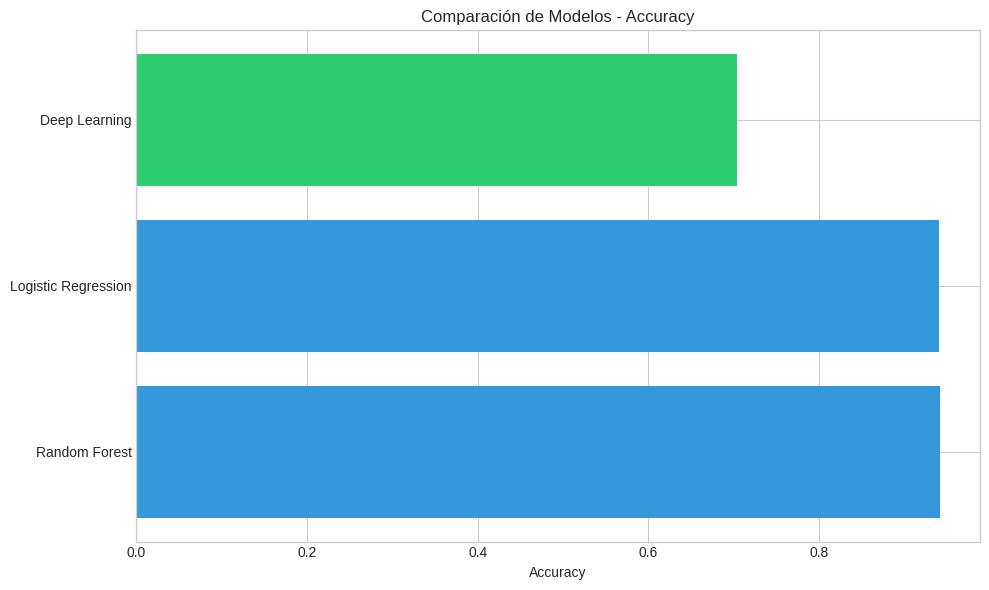

In [30]:
# =====================================================
# COMPARACIÓN CON MODELO BASELINE
# =====================================================

print("=" * 60)
print("COMPARACIÓN CON MODELO BASELINE")
print("=" * 60)

if task_type == 'classification':
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression

    # Modelos baseline
    baselines = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }
else:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression

    baselines = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
    }

# Entrenar y evaluar baselines
results = {'Modelo': [], 'Métrica': []}

for name, model in baselines.items():
    model.fit(X_train, y_train)
    y_pred_baseline = model.predict(X_test)

    if task_type == 'classification':
        metric = accuracy_score(y_test, y_pred_baseline)
        metric_name = 'Accuracy'
    else:
        metric = r2_score(y_test, y_pred_baseline)
        metric_name = 'R²'

    results['Modelo'].append(name)
    results['Métrica'].append(metric)

# Agregar modelo de Deep Learning
results['Modelo'].append('Deep Learning')
if task_type == 'classification':
    results['Métrica'].append(accuracy)
else:
    results['Métrica'].append(r2)

# Mostrar comparación
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('Métrica', ascending=False)

print(f"\n📊 Comparación de Modelos ({metric_name}):")
display(comparison_df)

# Visualización
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if m == 'Deep Learning' else '#3498db' for m in comparison_df['Modelo']]
plt.barh(comparison_df['Modelo'], comparison_df['Métrica'], color=colors)
plt.xlabel(metric_name)
plt.title(f'Comparación de Modelos - {metric_name}')
plt.tight_layout()
plt.show()

### 8.3 Análisis de Resultados

**Instrucciones:** Analice los resultados obtenidos:

---

**Rendimiento del Modelo:**
En el conjunto de test, el modelo de Deep Learning alcanzó un Accuracy = 0.7044 y un F1-score weighted = 0.7819. Sin embargo, al revisar el desempeño por clase se observa un comportamiento desigual: para la clase 0 (no compra) el modelo obtiene un rendimiento alto (precision 0.97, recall 0.71, f1 0.82), mientras que para la clase 1 (compra) logra recall 0.65 pero con precision 0.12 y f1 0.21. Esto significa que el modelo sí recupera una parte importante de los compradores reales (TP=176 de 269), pero también genera muchos falsos positivos (FP=1237). La matriz de confusión confirma esto: TN=2994, FP=1237, FN=93, TP=176.

**Comparación con Baselines:**
Al comparar con modelos baseline, el Deep Learning quedó por debajo en accuracy: Random Forest = 0.9416 y Logistic Regression = 0.9402, frente a Deep Learning = 0.7044. Esto sugiere que, con las variables disponibles, los modelos tradicionales están capturando mejor el patrón general. Aun así, el valor del DL puede estar en su capacidad de “traer” compradores (recall de clase 1), aunque actualmente lo hace con un costo alto de falsos positivos.

**Fortalezas del Modelo:**
1. Buen recall en clase positiva (0.65): identifica una proporción relevante de compradores reales (176 de 269), lo que puede ser útil si el negocio prioriza “no perder oportunidades”.
2. Entrenamiento estable: la pérdida de validación mejora hasta un mínimo (val_loss 0.5678) y el accuracy de validación llega a un pico (val_acc 0.7643), indicando que el modelo aprende patrones en los datos.

**Debilidades del Modelo:**
1. Baja precisión para compradores (0.12): predice muchos compradores que en realidad no lo son (FP=1237), lo cual puede generar costos operativos altos (contactar muchos clientes “no propensos”).
2. Desempeño inferior a baselines: tanto Random Forest como Regresión Logística superan ampliamente al DL en accuracy, por lo que el DL no es la mejor alternativa “por defecto” en esta versión.

**Posibles Mejoras:**
1. Ajustar el umbral de decisión o calibración de probabilidades para reducir falsos positivos, buscando un balance entre precision y recall (optimizar F1 de clase 1 o PR-AUC).
2. Manejo del desbalance (class weights, focal loss, oversampling/undersampling) para mejorar la discriminación real de la clase 1 y no “compensar” con demasiadas predicciones positivas.

---

---
## 9. Interpretación de Resultados

### 9.1 Importancia de Features (SHAP)

In [31]:
# =====================================================
# INTERPRETABILIDAD CON SHAP (OPCIONAL)
# =====================================================

# Instalar SHAP si no está disponible
# !pip install shap

try:
    import shap

    print("=" * 60)
    print("ANÁLISIS DE IMPORTANCIA DE FEATURES (SHAP)")
    print("=" * 60)

    # Crear explainer
    # Usar una muestra del dataset para acelerar el cálculo
    sample_size = min(100, len(X_test))
    X_sample = X_test.iloc[:sample_size]

    # Para modelos de sklearn (baselines)
    explainer = shap.TreeExplainer(baselines['Random Forest'])
    shap_values = explainer.shap_values(X_sample)

    # Visualización
    plt.figure(figsize=(12, 8))
    if task_type == 'classification' and len(shap_values) > 1:
        shap.summary_plot(shap_values[1], X_sample, plot_type="bar", show=False)
    else:
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title('Importancia de Features (SHAP)')
    plt.tight_layout()
    plt.show()

except ImportError:
    print("⚠️ SHAP no está instalado. Ejecute: !pip install shap")
except Exception as e:
    print(f"⚠️ Error en análisis SHAP: {e}")

ANÁLISIS DE IMPORTANCIA DE FEATURES (SHAP)
⚠️ Error en análisis SHAP: The shape of the shap_values matrix does not match the shape of the provided data matrix.


<Figure size 1200x800 with 0 Axes>

### 9.2 Interpretación de Negocios

**Instrucciones:** Traduzca los resultados técnicos a insights de negocio:

---

**Insights Principales:**
1. El modelo es útil como herramienta para detectar potenciales compradores, ya que recupera 65% de los compradores reales en test (recall clase 1 = 0.65).
2. El principal problema práctico es que, por cada comprador detectado, el modelo está marcando a muchos no compradores: su precision de 0.12 implica un volumen elevado de contactos “innecesarios”, lo que afecta costo y eficiencia comercial.
3. Los baselines (Random Forest y Regresión Logística) muestran un desempeño general muy superior (accuracy ~0.94), por lo que en un escenario real serían la primera alternativa si el objetivo es maximizar exactitud global; el DL solo tendría sentido si se optimiza para una meta específica (ej. recall o lift comercial).

**Factores Más Importantes:**
A falta de una interpretación completa con SHAP (pendiente de corrección técnica), los modelos baseline como Random Forest pueden servir para estimar importancia de variables. En negocio, los “factores importantes” representan qué características del cliente aumentan o reducen la probabilidad de compra, y pueden usarse para segmentación, diseño de campañas y personalización de ofertas.

**Patrones Identificados:**
El patrón más claro en los resultados es el desbalance: el modelo aprende muy bien a clasificar “no compra”, pero cuando intenta capturar “compra” lo hace con un trade-off agresivo, aumentando falsos positivos. Esto sugiere que el caso requiere definir una estrategia comercial explícita: ¿prefiero traer más compradores (recall alto) aunque contacte muchos falsos? o ¿prefiero contactar pocos pero casi seguros (precision alta)?

---

---
## 10. Conclusiones y Recomendaciones de Negocio

### 10.1 Resumen de Resultados

**Instrucciones:** Proporcione un resumen ejecutivo de los resultados:

---

En este proyecto se construyó un modelo de propensión para predecir la compra de un seguro vehicular usando una red neuronal tipo MLP sobre datos tabulares. Se aplicaron etapas de preprocesamiento (tratamiento de faltantes, detección de outliers y escalado) y se dividieron los datos en entrenamiento, validación y test. El entrenamiento mostró comportamiento estable: se completaron 73 épocas, logrando el mejor val_loss = 0.5678 (época 63) y el mejor val_acc = 0.7643 (época 13).

En evaluación final sobre el conjunto de test, el modelo alcanzó Accuracy = 0.7044 y F1 weighted = 0.7819. Sin embargo, el desempeño por clase revela un trade-off importante: la clase positiva (compra) obtuvo recall = 0.65 pero precision = 0.12, generando muchos falsos positivos. Finalmente, al comparar con modelos baseline, el Deep Learning quedó por debajo: Random Forest = 0.9416 y Regresión Logística = 0.9402 en accuracy, por lo que se recomienda optimizar el modelo DL para un objetivo específico del negocio o utilizar los modelos clásicos como punto de partida.

---

### 10.2 Conclusiones

**Instrucciones:** Liste las conclusiones principales:

---

1. El modelo de Deep Learning obtiene un desempeño moderado (accuracy 0.7044) pero no supera a los baselines en exactitud global.
2. El modelo presenta un patrón clave: recall alto en compradores (0.65) pero con precision muy baja (0.12), lo que genera muchos falsos positivos.
3. La matriz de confusión confirma el trade-off: TP=176 compradores detectados vs FP=1237 no compradores marcados como compradores.
4. Los modelos baseline (Random Forest y Regresión Logística) alcanzan accuracy ~0.94, indicando que con las features actuales los enfoques clásicos explican mejor el patrón general.

---

### 10.3 Recomendaciones de Negocio

**Instrucciones:** Proporcione recomendaciones accionables basadas en los resultados:

---

**Recomendaciones a Corto Plazo:**
1. Usar el modelo como modelo de priorización (ranking) y no como decisión binaria directa, para que el equipo comercial trabaje primero con los casos más probables.
2. Definir el objetivo comercial (minimizar falsos positivos vs maximizar captura de compradores) y ajustar el umbral para controlar el volumen de contactos.

**Recomendaciones a Mediano Plazo:**
1. Implementar técnicas de manejo del desbalance (class weights, focal loss, oversampling) para mejorar la precisión de la clase positiva sin perder demasiado recall.
2. Revisar y enriquecer variables (feature engineering): historial de comportamiento, segmentación, interacciones, variables agregadas, etc., para aumentar separabilidad entre compra/no compra.

**Recomendaciones a Largo Plazo:**
1. Evaluar el modelo con métricas de negocio: lift en top-k, tasa de conversión incremental, ROI de campañas, no solo accuracy.
2. Implementar monitoreo y reentrenamiento periódico para asegurar que el modelo se mantenga alineado con cambios en el comportamiento de clientes.

---

### 10.4 Limitaciones del Estudio

**Instrucciones:** Identifique las limitaciones de su análisis:

---

1. Desbalance de clases (clase 1 con soporte 269 vs clase 0 con 4231), lo que afecta el comportamiento del modelo y requiere métricas más específicas.
2. Se evaluó principalmente con métricas estándar; faltaría incorporar métricas orientadas a campañas como PR-AUC, lift y análisis top-k.
3. La interpretabilidad con SHAP aún está pendiente por un problema técnico de shape, limitando el análisis detallado de drivers.

---

### 10.5 Trabajo Futuro

**Instrucciones:** Proponga líneas de investigación futura:

---

1. Ajustar el umbral de clasificación usando la curva Precision-Recall para encontrar el mejor punto según objetivo del negocio.
2. Probar técnicas de desbalance (class weights/focal loss/sampling) y comparar con modelos avanzados para tabular como XGBoost/LightGBM.
3. Corregir e integrar interpretabilidad (SHAP) y realizar análisis por segmentos (tipo de cliente, rangos de variables) para acciones comerciales.

---

---
## 11. Referencias

**Instrucciones:** Liste todas las referencias utilizadas (formato APA):

---

1. Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.
2. Pedregosa, F., Varoquaux, G., Gramfort, A., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830.
3. Lundberg, S. M., & Lee, S.-I. (2017). A unified approach to interpreting model predictions. Advances in Neural Information Processing Systems (NeurIPS).

---

---
## Anexos

### A. Guardado del Modelo

In [35]:
# =====================================================
# GUARDAR EL MODELO ENTRENADO
# =====================================================

print("=" * 60)
print("GUARDADO DEL MODELO")
print("=" * 60)

# Guardar modelo PyTorch
MODEL_PATH = 'modelo_final.pth'
torch.save({
    'model_state_dict': model_pytorch.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'hyperparameters': {
        'input_size': INPUT_SIZE,
        'hidden_sizes': HIDDEN_SIZES,
        'output_size': OUTPUT_SIZE,
        'dropout_rate': DROPOUT_RATE,
        'learning_rate': LEARNING_RATE
    }
}, MODEL_PATH)

print(f"\n✅ Modelo PyTorch guardado en: {MODEL_PATH}")

# Guardar modelo Keras (opcional)
# model_keras.save('modelo_final.keras')
# print(f"✅ Modelo Keras guardado en: modelo_final.keras")

# Guardar scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')
print(f"✅ Scaler guardado en: scaler.pkl")

GUARDADO DEL MODELO

✅ Modelo PyTorch guardado en: modelo_final.pth
✅ Scaler guardado en: scaler.pkl


### B. Cargar Modelo Guardado (para Inferencia)

In [36]:
# =====================================================
# CARGAR MODELO PARA INFERENCIA
# =====================================================

def load_model_and_predict(model_path, scaler_path, new_data):
    """
    Carga el modelo entrenado y hace predicciones sobre nuevos datos.

    Args:
        model_path: Ruta al archivo del modelo
        scaler_path: Ruta al archivo del scaler
        new_data: DataFrame con los nuevos datos

    Returns:
        Predicciones
    """
    # Cargar checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Reconstruir modelo
    hp = checkpoint['hyperparameters']
    model = NeuralNetwork(
        hp['input_size'],
        hp['hidden_sizes'],
        hp['output_size'],
        hp['dropout_rate']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Cargar scaler
    scaler = joblib.load(scaler_path)

    # Preprocesar datos
    new_data_scaled = scaler.transform(new_data)
    new_data_tensor = torch.FloatTensor(new_data_scaled).to(device)

    # Hacer predicción
    with torch.no_grad():
        outputs = model(new_data_tensor)
        if task_type == 'classification':
            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().numpy()
        else:
            predictions = outputs.cpu().numpy().flatten()

    return predictions

# Ejemplo de uso:
# predictions = load_model_and_predict('modelo_final.pth', 'scaler.pkl', new_df)
print("✅ Función de carga e inferencia definida")

✅ Función de carga e inferencia definida


---

## Checklist de Entrega

Antes de entregar, verifique que ha completado los siguientes elementos:

- [ ] Información del proyecto completada
- [ ] Resumen ejecutivo escrito
- [ ] Problema de negocio claramente definido
- [ ] Objetivos SMART establecidos
- [ ] EDA completo con visualizaciones
- [ ] Preprocesamiento de datos documentado
- [ ] Arquitectura del modelo justificada
- [ ] Modelo entrenado con curvas de aprendizaje
- [ ] Métricas de evaluación calculadas
- [ ] Comparación con modelos baseline
- [ ] Interpretación de resultados
- [ ] Conclusiones y recomendaciones de negocio
- [ ] Referencias listadas
- [ ] Código ejecutable sin errores
- [ ] Comentarios y documentación adecuados

---

**¡Buena suerte con su proyecto!** 🎓

## Exportar como HTML

In [37]:
# Source - https://stackoverflow.com/a/64487858
# Posted by zabop, modified by community. See post 'Timeline' for change history
# Retrieved 2026-02-16, License - CC BY-SA 4.0

%%shell
jupyter nbconvert --to html /content/drive/MyDrive/AML_Final_Project/AML-Final-Project-Rojas-Keneth.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/AML_Final_Project/AML-Final-Project-Rojas-Keneth.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 1212117 bytes to /content/drive/MyDrive/AML_Final_Project/AML-Final-Project-Rojas-Keneth.html
